<a href="https://colab.research.google.com/github/reitezuz/18NES1-2025-/blob/main/week13/neural_gas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural gas - simple example

## Algorithm Steps

1. **Initialize** `k` neurons with random positions in the data space.
2. For a fixed number of **epochs**:
   - Shuffle the training data.
   - For each data point `x`:
     1. Compute distances from `x` to all neurons.
     2. Sort the neurons by increasing distance (rank them).
     3. Update each neuron based on its rank:

  $$
      \mathbf{w}_i \leftarrow \mathbf{w}_i + \alpha \cdot h(k_i) \cdot (\mathbf{x} - \mathbf{w}_i)
  $$

      Where:

      - $\alpha$ is the learning rate (decreases over time)
      - $h(k_i) = \exp(-k_i / \lambda)$ is the neighborhood function (based on rank $k_i$)
      - $k_i$ is the rank of neuron $i$ for input $\mathbf{x}$
      - $\lambda$ is the neighborhood width (also decreases over time)
       
3. After training, the neuron positions represent the learned structure of the data.

## Parameters

- `n_neurons`: Number of representants (neurons)
- `n_epochs`: Number of training epochs
- `learning_rate`: Initial step size (e.g. 0.5)
- `lambda`: Initial neighborhood width (usually ≈ n_neurons / 2)


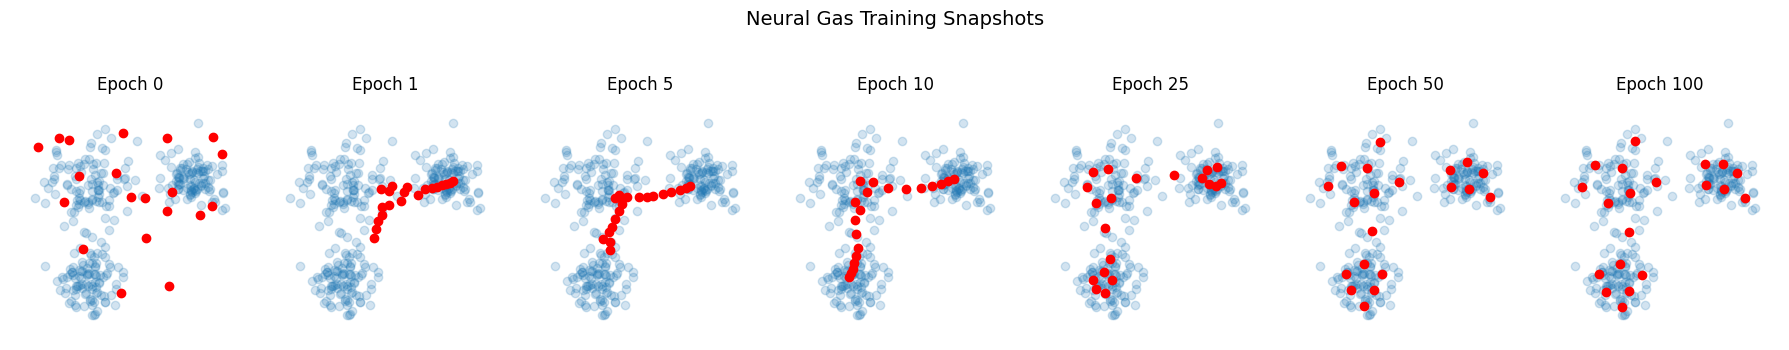

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- Generate synthetic data ---
np.random.seed(42)
data1 = np.random.randn(100, 2) * 0.7 + [2, 2]
data2 = np.random.randn(100, 2) * 0.6 + [6, 6]
data3 = np.random.randn(100, 2) * 0.9 + [2, 6]
data = np.vstack([data1, data2, data3])

# --- Neural Gas setup ---
n_neurons = 20
n_epochs = 100
snapshots = [0, 1, 5, 10, 25, 50, 100]
#snapshots = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
learning_rate_initial = 0.5
lambda_initial = n_neurons / 2

neurons = np.random.uniform(low=data.min(axis=0), high=data.max(axis=0), size=(n_neurons, 2))
history = {0: neurons.copy()}  # save initial state

# --- Training with snapshots ---
for epoch in range(1, n_epochs + 1):
    np.random.shuffle(data)
    lr = learning_rate_initial * (0.01 / learning_rate_initial) ** (epoch / n_epochs)
    lambd = lambda_initial * (0.01 / lambda_initial) ** (epoch / n_epochs)

    for x in data:
        distances = np.linalg.norm(neurons - x, axis=1)
        ranks = np.argsort(distances)
        for k, i in enumerate(ranks):
            h = np.exp(-k / lambd)
            neurons[i] += lr * h * (x - neurons[i])

    if epoch in snapshots:
        history[epoch] = neurons.copy()

# --- Plot snapshots ---
fig, axes = plt.subplots(1, len(snapshots), figsize=(18, 4))
for ax, epoch in zip(axes, snapshots):
    ax.scatter(data[:, 0], data[:, 1], alpha=0.2, label='Data')
    n = history[epoch]
    ax.scatter(n[:, 0], n[:, 1], color='red', label='Neurons')

    # Optionally: connect neurons
    #for i in range(len(n)):
    #    for j in range(i + 1, len(n)):
    #        ax.plot([n[i, 0], n[j, 0]], [n[i, 1], n[j, 1]], color='gray', alpha=0.05)

    ax.set_title(f"Epoch {epoch}")
    ax.set_xlim(data[:, 0].min() - 1, data[:, 0].max() + 1)
    ax.set_ylim(data[:, 1].min() - 1, data[:, 1].max() + 1)
    ax.set_aspect('equal')
    ax.axis('off')

plt.suptitle("Neural Gas Training Snapshots", fontsize=14)
plt.tight_layout()
plt.show()


# Comparison of Neural Gas with the Winner Takes All Algorithm

In [8]:
def neural_gas_train(data, n_neurons=20, n_epochs=100, snapshots=None,
                     learning_rate_initial=0.5, lambda_initial=None, random_state=None):
    """
    Trains the Neural Gas algorithm on input data.

    Parameters:
    - data: array of shape (n_samples, n_features)
    - n_neurons: number of reference vectors
    - n_epochs: number of training epochs
    - snapshots: list of epochs at which to store neuron states (e.g. [0, 1, 5, 10, 100])
    - learning_rate_initial: initial learning rate
    - lambda_initial: initial neighborhood width (default = n_neurons / 2)
    - random_state: int for reproducibility

    Returns:
    - history: dict {epoch: neuron_positions}
    """
    if snapshots is None:
        snapshots = [0, n_epochs]
    if lambda_initial is None:
        lambda_initial = n_neurons / 2
    if random_state is not None:
        np.random.seed(random_state)

    neurons = np.random.uniform(low=data.min(axis=0), high=data.max(axis=0), size=(n_neurons, data.shape[1]))
    history = {0: neurons.copy()}

    for epoch in range(1, n_epochs + 1):
        np.random.shuffle(data)
        lr = learning_rate_initial * (0.01 / learning_rate_initial) ** (epoch / n_epochs)
        lambd = lambda_initial * (0.01 / lambda_initial) ** (epoch / n_epochs)

        for x in data:
            distances = np.linalg.norm(neurons - x, axis=1)
            ranks = np.argsort(distances)
            for k, i in enumerate(ranks):
                h = np.exp(-k / lambd)
                neurons[i] += lr * h * (x - neurons[i])

        if epoch in snapshots:
            history[epoch] = neurons.copy()

    return history


def wta_train(data, n_neurons=20, n_epochs=100, snapshots=None,
              learning_rate_initial=0.5, random_state=None):
    """
    Trains a basic Winner-Takes-All (WTA) competitive learning model.

    Parameters:
    - data: array of shape (n_samples, n_features)
    - n_neurons: number of prototype vectors
    - n_epochs: number of training epochs
    - snapshots: list of epochs to save neuron states (e.g. [0, 10, 50, 100])
    - learning_rate_initial: starting learning rate
    - random_state: seed for reproducibility

    Returns:
    - history: dict {epoch: neuron_positions}
    """
    if snapshots is None:
        snapshots = [0, n_epochs]
    if random_state is not None:
        np.random.seed(random_state)

    neurons = np.random.uniform(low=data.min(axis=0), high=data.max(axis=0), size=(n_neurons, data.shape[1]))
    history = {0: neurons.copy()}

    for epoch in range(1, n_epochs + 1):
        np.random.shuffle(data)
        lr = learning_rate_initial * (0.01 / learning_rate_initial) ** (epoch / n_epochs)

        for x in data:
            winner_idx = np.argmin(np.linalg.norm(neurons - x, axis=1))
            neurons[winner_idx] += lr * (x - neurons[winner_idx])

        if epoch in snapshots:
            history[epoch] = neurons.copy()

    return history

    import matplotlib.pyplot as plt

def plot_snapshots(data, history, snapshots, title="Neuron Snapshots", color='red'):
    """
    Plots training snapshots of neurons for visualization.

    Parameters:
    - data: array of shape (n_samples, n_features)
    - history: dict {epoch: neuron_positions}, as returned by training function
    - snapshots: list of epochs to plot
    - title: plot title
    - color: color of neuron points
    """
    n_cols = len(snapshots)
    fig, axes = plt.subplots(1, n_cols, figsize=(4 * n_cols, 4))

    if n_cols == 1:
        axes = [axes]

    for ax, epoch in zip(axes, snapshots):
        ax.scatter(data[:, 0], data[:, 1], alpha=0.2, label='Data')
        neurons = history[epoch]
        ax.scatter(neurons[:, 0], neurons[:, 1], color=color, label='Neurons')

        ax.set_title(f"Epoch {epoch}")
        ax.set_xlim(data[:, 0].min() - 1, data[:, 0].max() + 1)
        ax.set_ylim(data[:, 1].min() - 1, data[:, 1].max() + 1)
        ax.set_aspect('equal')
        ax.axis('off')

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()



Data shape: (150, 4)


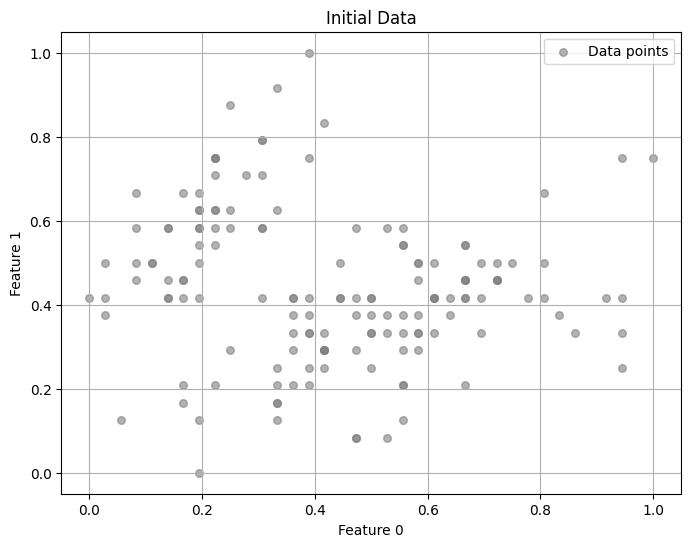

In [12]:
# Choose dataset
dataset_choice = 'iris'  # options: 'blobs1', 'blobs2', 'moons', 'circles', 'iris',

import numpy as np
from sklearn.datasets import make_blobs, make_circles, make_moons, load_iris
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def get_dataset(dataset_choice):
    if dataset_choice == 'blobs1':
        data, _ = make_blobs(n_samples=300, centers=[[1,1], [-1,-1], [2,-2]], cluster_std=[0.75, 0.5, 0.5], random_state=42)
        #data, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=42)
    elif dataset_choice == 'blobs2':
        data, _ = make_blobs(n_samples=400, centers=[[1,1], [1,-0.5], [-1,-1], [2,-2]], cluster_std=[0.25, 0.75, 0.5, 0.5], random_state=42)

    elif dataset_choice == 'moons':
        data = make_moons(n_samples=300, noise=0.1, random_state=42)[0]
    elif dataset_choice == 'circles':
        data = make_circles(n_samples=300, factor=0.5, noise=0.05, random_state=42)[0]

    elif dataset_choice == 'iris':
        iris = load_iris()
        data = iris.data
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)
    else:
        raise ValueError("Unknown dataset choice.")
    return data

data = get_dataset(dataset_choice)
print(f'Data shape: {data.shape}')



# Choose dimensions to plot (in case of higher dimensional data)
dims = (0, 1)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(data[:, dims[0]], data[:, dims[1]], c='gray', s=30, alpha=0.6, label='Data points')
plt.xlabel(f'Feature {dims[0]}')
plt.ylabel(f'Feature {dims[1]}')
plt.title('Initial Data')
plt.legend()
plt.grid(True)
plt.show()


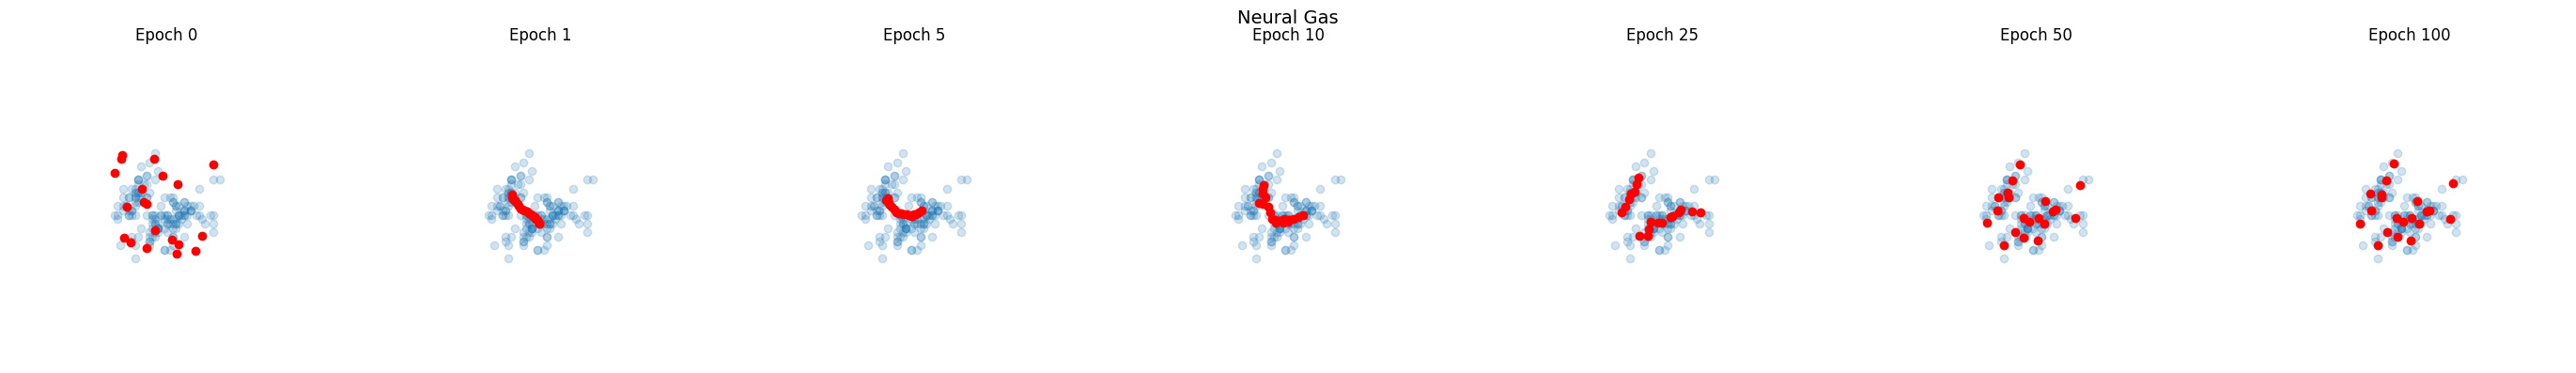

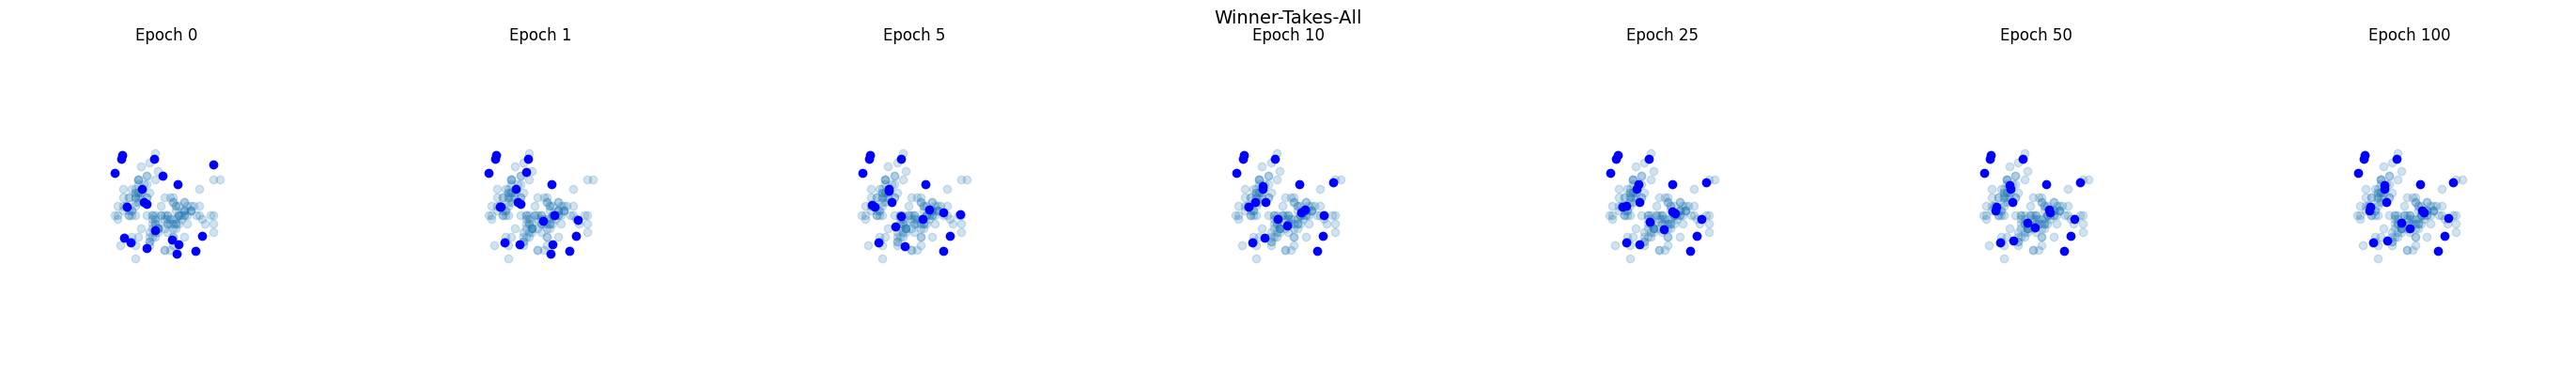

In [13]:
snapshots = [0, 1, 5, 10, 25, 50, 100]

# Neural Gas training
ng_history = neural_gas_train(data, n_neurons=20, n_epochs=100, snapshots=snapshots, random_state=42)

# WTA training
wta_history = wta_train(data, n_neurons=20, n_epochs=100, snapshots=snapshots, random_state=42)


# Visualize
plot_snapshots(data, ng_history, snapshots, title="Neural Gas", color='red')
plot_snapshots(data, wta_history, snapshots, title="Winner-Takes-All", color='blue')